In [6]:
import sys
sys.path.append('../../../botop/build')
print(sys.version)
import numpy as np
import libry as ry
import libpybot as pybot
import time
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', **{'size': 16})
plt.rcParams.update({
  "text.usetex": True
})

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]


In [2]:
C = ry.Config()
C.view()
C.addFile("../../../botop/rai-robotModels/scenarios/pandaSingle.g")

In [3]:
bot = pybot.BotOp(C, False)

In [4]:
bot.home(C)

In [4]:
jointID = 6

In [7]:
def plot_viapoint(viapoint):
    print('Viapoints', *viapoint, sep=':')
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(len(viapoint)), viapoint, 'rx', label='via point')
    plt.grid()
    plt.xlabel("sequence of via point")
    plt.ylabel("joint degree [rad]")
    plt.legend()
    plt.savefig("/home/jiayun/Desktop/via_points.jpg", dpi=200)
    plt.show()
    
def generateViaPoint(q_min, q_max):
    '''
    y = t + A*sin(theta + alpha*t) + bias
    y0 = A*sin(theta) + bias
    yend = Direct cut-off
    '''
    t = np.linspace(0,10,1000)
    A = 0.8
    theta = 0
    alpha = 5
    bias = q_min
    y = t + A*np.sin(theta + alpha*t) + bias
    indicator = y < q_max
    indicator = [i for i, x in enumerate(indicator) if not x]
    y = y[:indicator[0]]
    point = []
    for idx, it in enumerate(y):
        if idx == 0:
            point.append(it)
        elif idx != len(y)-1:
            isCriticalPoint = (it > y[idx-1] and it > y[idx+1]) or (it < y[idx-1] and it < y[idx+1])
            point.append(y[idx]) if isCriticalPoint else _
        else:
            point.append(it)
    return point

Viapoints:-2.8100335374002836:-1.6709238353092286:-2.692677774167917:-0.414105300288107:-1.4359275799680686:0.8422993238769956:-0.17938255660409563:2.099167471649626:1.077299362190551:2.782182392854834


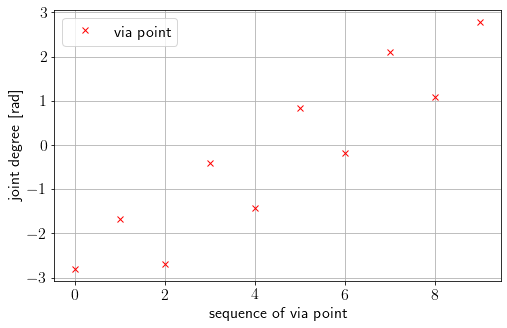

In [8]:
q_min = [-2.8973, -1.7628, -2.8973, -3.0718, -2.8973, 0.1, -2.8973]
q_max = [ 2.8973, 1.7628, 2.8973, -0.0698, 2.8973, 3.7525, 2.8973]

for i in range(0,7):
    exec('viapoint_q{} = generateViaPoint(q_min[{}] + np.radians(5), q_max[{}] - np.radians(5))'.\
         format(i, i, i))

plot_viapoint(viapoint_q0)

In [8]:
def joint_selection(k):
    q = bot.get_q()[np.newaxis, :]
    q = np.tile(q, (len(eval("viapoint_q" + str(k))), 1))
    q[:,k] = eval("viapoint_q" + str(k))
    return q

In [9]:
## preposition it
bot.home(C)

if jointID==1:
    q = bot.get_qHome()
    q[2] = 1.5
    bot.moveLeap(q, 1)

    while bot.getTimeToEnd()>0:
        bot.step(C, .1)
        time.sleep(.1)

In [10]:
%%time

#bot.home(C)
q = joint_selection(jointID)
timing = 1*np.arange(0, q.shape[0])+2  # where to change the time -> velocity
print(timing)

bot.setControllerWriteData(2)
bot.move(q, timing)
#for q_t in q:
#    bot.move(q_t.reshape(1,7), [10])
#bot.moveAutoTimed(q, 1)

while bot.getTimeToEnd()>0:
    bot.step(C, .1)
    time.sleep(.1)

[ 2  3  4  5  6  7  8  9 10 11]
CPU times: user 3.13 s, sys: 957 ms, total: 4.08 s
Wall time: 11.2 s


In [11]:
bot.setControllerWriteData(0)
bot.home(C)

In [12]:
bot = 0

In [13]:
C.view_close()

In [14]:
C = 0